In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

100%|██████████| 170498071/170498071 [00:06<00:00, 27309839.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Batch shape: torch.Size([100, 3, 32, 32]), Labels shape: torch.Size([100])


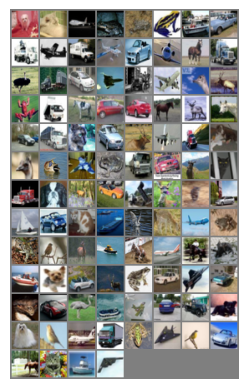

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Check the shape of the dataset
dataiter = next(iter(trainloader))
images, labels = dataiter
print(f'Batch shape: {images.shape}, Labels shape: {labels.shape}')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Make a grid from batch
imshow(torchvision.utils.make_grid(images))

# Display the plot
plt.show()


In [3]:
import torch.nn as nn
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

In [4]:
net = BasicUNet().cuda()
x = torch.rand(8, 3, 32, 32).cuda()
net(x).shape

torch.Size([8, 3, 32, 32])

In [5]:
sum([p.numel() for p in net.parameters()])

312259

Finished epoch 0. Average loss for this epoch: 0.056314
Finished epoch 1. Average loss for this epoch: 0.049289
Finished epoch 2. Average loss for this epoch: 0.048572


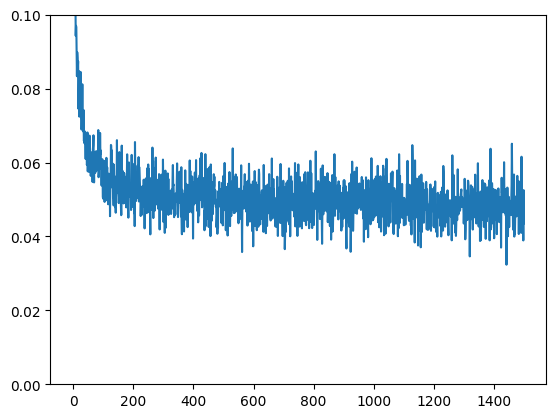

In [6]:
# Dataloader (you can mess with batch size)
# batch_size = 128
# trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
device = "cuda"
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in trainloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
#         noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
#         noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(trainloader):])/len(trainloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

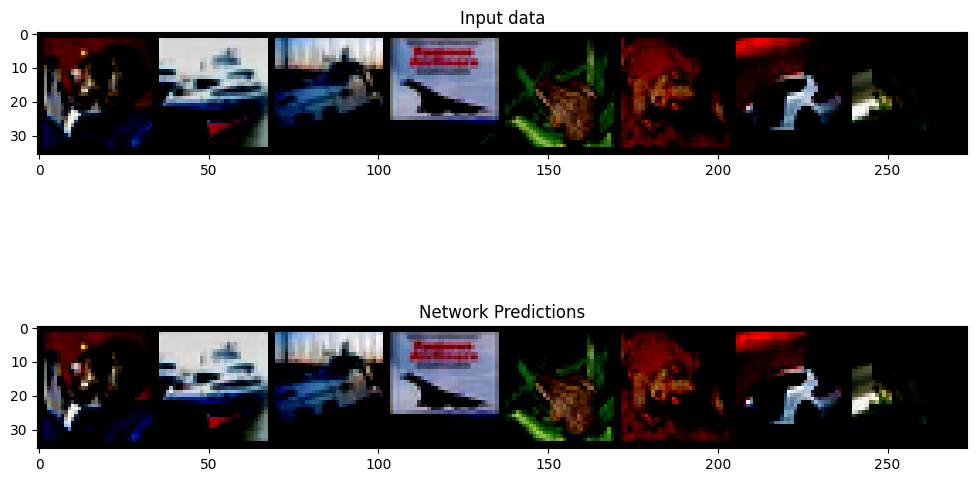

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Assuming `net` is your trained model and `device` is set (e.g., 'cuda' or 'cpu')

# Get a batch of training data
x, y = next(iter(testloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Assuming you have a `corrupt` function that adds noise to images
# amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
# noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# Display the original input data
axs[0].set_title('Input data')
axs[0].imshow(np.transpose(torchvision.utils.make_grid(x, nrow=8).numpy(), (1, 2, 0)).clip(0, 1))

# If you want to show corrupted data, uncomment the following lines:
# axs[1].set_title('Corrupted data')
# axs[1].imshow(np.transpose(torchvision.utils.make_grid(noised_x, nrow=8).numpy(), (1, 2, 0)).clip(0, 1))

# Display the network predictions
axs[1].set_title('Network Predictions')
axs[1].imshow(np.transpose(torchvision.utils.make_grid(preds, nrow=8).numpy(), (1, 2, 0)).clip(0, 1))

plt.show()


# Add Noise

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Model 


import torch.nn as nn
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x
    

class NoisyCIFAR10(Dataset):
        def __init__(self, root, train=True, transform=None, noise_level=0.1):
            """
            Initialize the dataset, loading the base CIFAR-10 dataset and applying the given transformations.
            Args:
            - root: The directory where the dataset will be stored.
            - train: Whether to load the training set (True) or the test set (False).
            - transform: The transformations to apply to the images.
            - noise_level: The fixed amount of noise to add to each image.
            """
            self.cifar10 = torchvision.datasets.CIFAR10(root=root, train=train, download=True, transform=transform)
            self.noise_level = noise_level

        def __len__(self):
            return len(self.cifar10)

        def __getitem__(self, idx):
            img, label = self.cifar10[idx]
            clean_img = img.clone()
            # Corrupt the image by adding noise
            noise = torch.rand_like(img)
            img = img * (1 - self.noise_level) + noise * self.noise_level

            return img, clean_img
    


In [10]:
testset = NoisyCIFAR10(root='./data', train=False, transform=transform, noise_level=1)
# print(testset[0].shape)
for img, clean_img in trainset:
    print(img.shape)
    break

Files already downloaded and verified
torch.Size([3, 32, 32])


In [11]:

def prediction_for_noise_level(noise):
    
    # Function 
    import torch
    import torchvision
    import torchvision.transforms as transforms
    from torch.utils.data import Dataset
    import matplotlib.pyplot as plt
    import numpy as np
    # Define the transform to normalize the data
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Initialize the dataset with noise corruption
    trainset = NoisyCIFAR10(root='./data', train=True, transform=transform, noise_level=noise)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
    testset = NoisyCIFAR10(root='./data', train=False, transform=transform, noise_level=noise)
    testloader = torch.utils.data.DataLoader(trainset, batch_size=100, num_workers=2)

    # Example: Display some images
    dataiter = next(iter(trainloader))
    images, labels = dataiter

    def imshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    net = BasicUNet().cuda()
    x = torch.rand(8, 3, 32, 32).cuda()
    net(x).shape
    # Dataloader (you can mess with batch size)
    # batch_size = 128
    # trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # How many runs through the data should we do?
    device = "cuda"
    n_epochs = 5

    # Create the network
    net = BasicUNet()
    net.to(device)

    # Our loss function
    loss_fn = nn.MSELoss()

    # The optimizer
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)

    # Keeping a record of the losses for later viewing
    losses = []

    # The training loop
    for epoch in range(n_epochs):

        for x, y in trainloader:

            # Get some data and prepare the corrupted version
            x = x.to(device) # Data on the GPU
            y = y.to(device)
    #         noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
    #         noisy_x = corrupt(x, noise_amount) # Create our noisy x

            # Get the model prediction
            pred = net(x)

            # Calculate the loss
            loss = loss_fn(pred, y) # How close is the output to the true 'clean' x?

            # Backprop and update the params:
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Store the loss for later
            losses.append(loss.item())

        # Print our the average of the loss values for this epoch:
        avg_loss = sum(losses[-len(trainloader):])/len(trainloader)
        print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')
    
    models.append(net)
        
    max_losses = []
    indices = []

    # Iterate over the testset without using a DataLoader to get index easily
    for index, (x, y) in enumerate(testset):
        with torch.no_grad():
            # Prepare the sample by adding a batch dimension and moving to the device
            x, y = x.unsqueeze(dim=0).to(device), y.unsqueeze(dim=0).to(device)

            # Get the model prediction
            pred = net(x)

            # Calculate the loss, assuming a simple MSE for individual predictions
            loss = ((pred - y) ** 2).mean().item()  # Calculating mean squared error

            # Store the loss and the corresponding index
            max_losses.append(loss)
            indices.append(index)

    # Combine the losses with their indices and sort them by loss
    indexed_losses = list(zip(max_losses, indices))
    indexed_losses.sort(reverse=True, key=lambda x: x[0])  # Sort by loss descending

    # Get the indices of the worst predictions
    worst_indices = [testset[idx] for _, idx in indexed_losses[:10]]
            
    # View the loss curve
    plt.plot(losses)
    plt.ylim(0, 0.1);
    import torch
    import torchvision
    import torchvision.transforms as transforms
    import matplotlib.pyplot as plt

    # Assuming `net` is your trained model and `device` is set (e.g., 'cuda' or 'cpu')

    # Get a batch of training data
    x, y = next(iter(testloader))
    x = x[:8]  # Only using the first 8 for easy plotting
    y = y[:8]

    # Assuming you have a `corrupt` function that adds noise to images
    # amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
    # noised_x = corrupt(x, amount)

    # Get the model predictions
    with torch.no_grad():
        preds = net(x.to(device)).detach().cpu()

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(12, 7))

    # Display the original input data
    axs[0].set_title('Input Corrupted data')
    axs[0].imshow(np.transpose(torchvision.utils.make_grid(x, nrow=8).numpy(), (1, 2, 0)).clip(0, 1))

#     If you want to show corrupted data, uncomment the following lines:
    axs[1].set_title('Clean data')
    axs[1].imshow(np.transpose(torchvision.utils.make_grid(y, nrow=8).numpy(), (1, 2, 0)).clip(0, 1))

    # Display the network predictions
    axs[2].set_title('Network Predictions')
    axs[2].imshow(np.transpose(torchvision.utils.make_grid(preds, nrow=8).numpy(), (1, 2, 0)).clip(0, 1))

    plt.show()
    
    return worst_indices
    

# Display images
# imshow(torchvision.utils.make_grid(images))
# plt.show()


0.0
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.055094
Finished epoch 1. Average loss for this epoch: 0.049157
Finished epoch 2. Average loss for this epoch: 0.048543
Finished epoch 3. Average loss for this epoch: 0.048254
Finished epoch 4. Average loss for this epoch: 0.048043


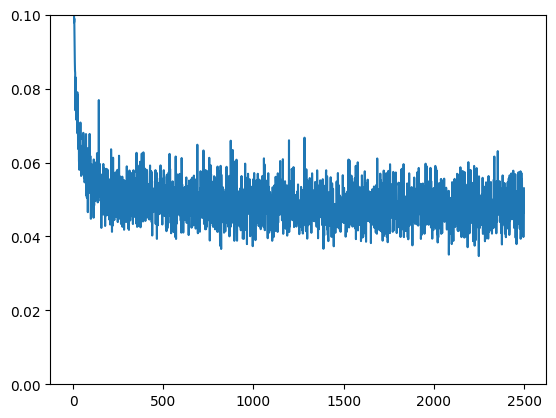

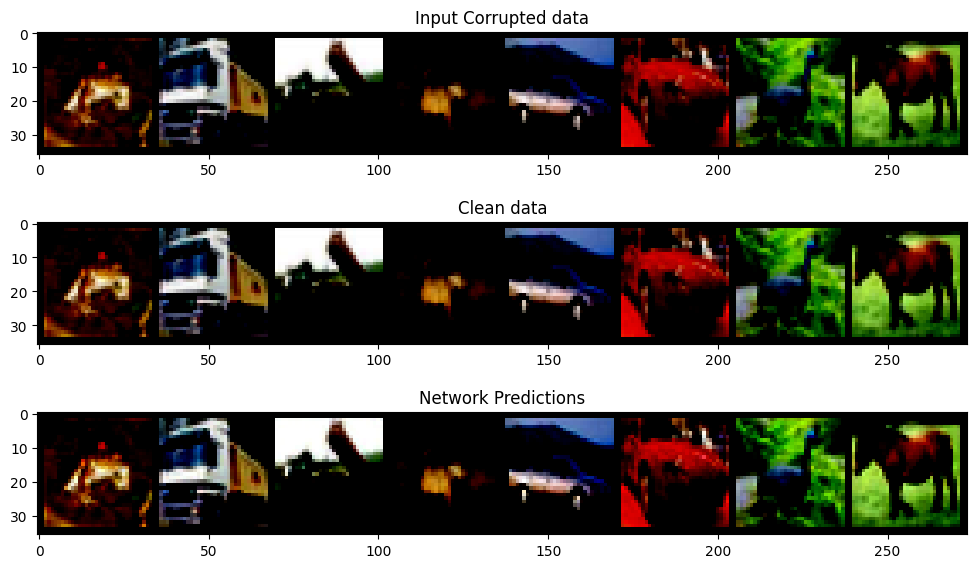

0.1
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.056853
Finished epoch 1. Average loss for this epoch: 0.049636
Finished epoch 2. Average loss for this epoch: 0.048957
Finished epoch 3. Average loss for this epoch: 0.048648
Finished epoch 4. Average loss for this epoch: 0.048467


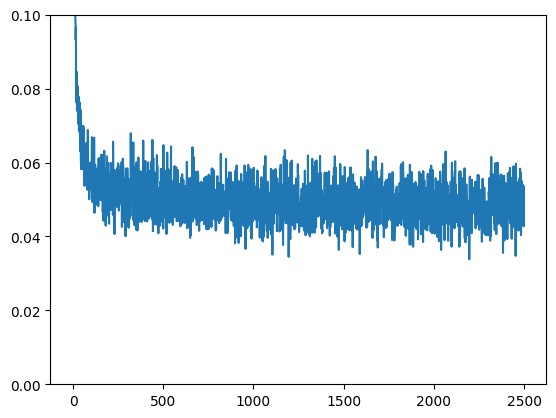

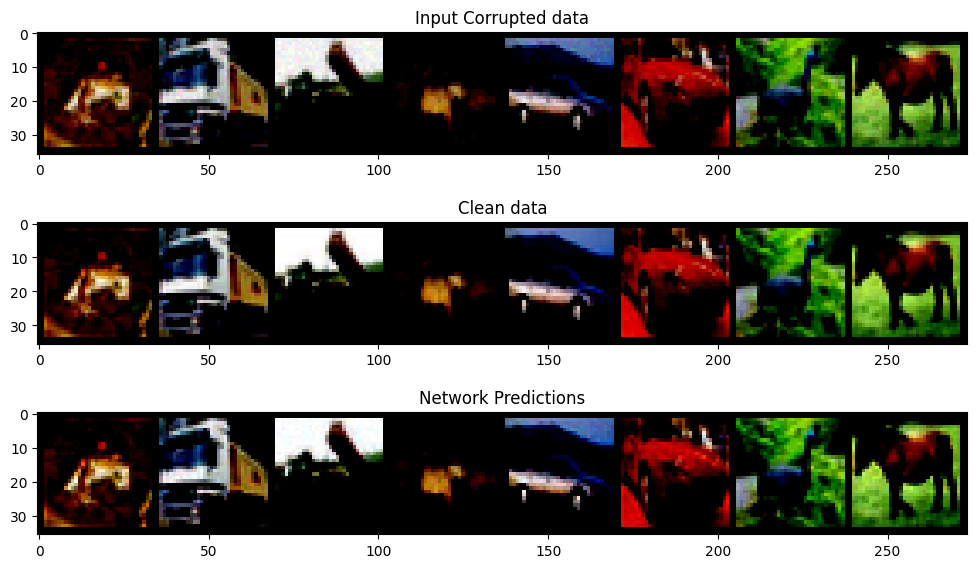

0.2
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.057907
Finished epoch 1. Average loss for this epoch: 0.050537
Finished epoch 2. Average loss for this epoch: 0.049871
Finished epoch 3. Average loss for this epoch: 0.049551
Finished epoch 4. Average loss for this epoch: 0.049343


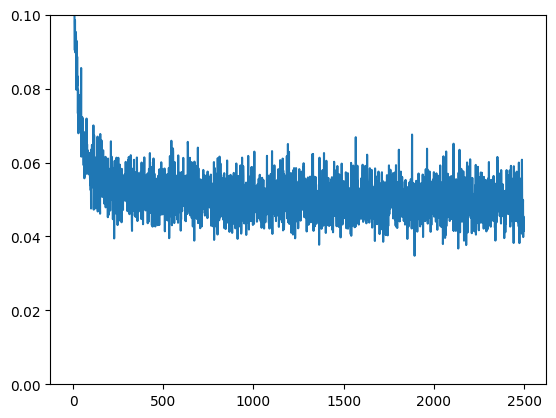

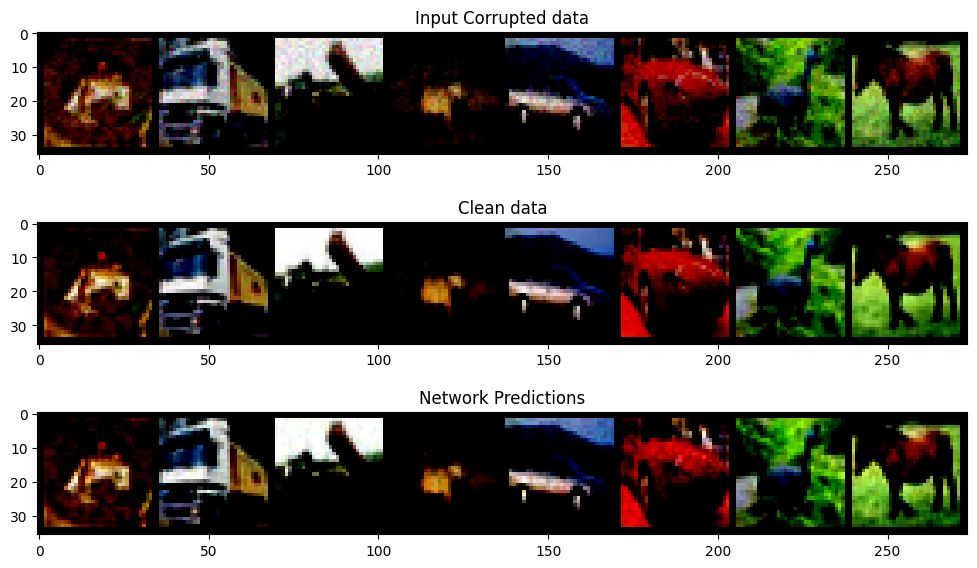

0.30000000000000004
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.058985
Finished epoch 1. Average loss for this epoch: 0.051851
Finished epoch 2. Average loss for this epoch: 0.051275
Finished epoch 3. Average loss for this epoch: 0.050971
Finished epoch 4. Average loss for this epoch: 0.050761


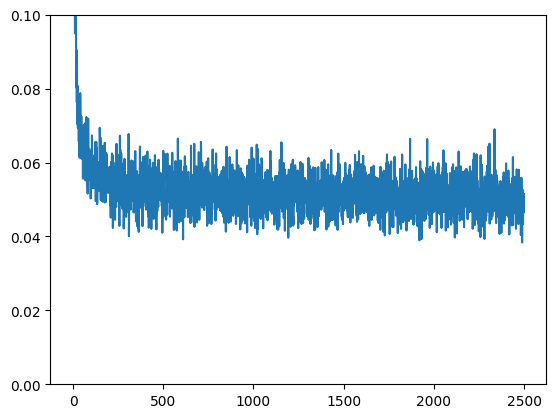

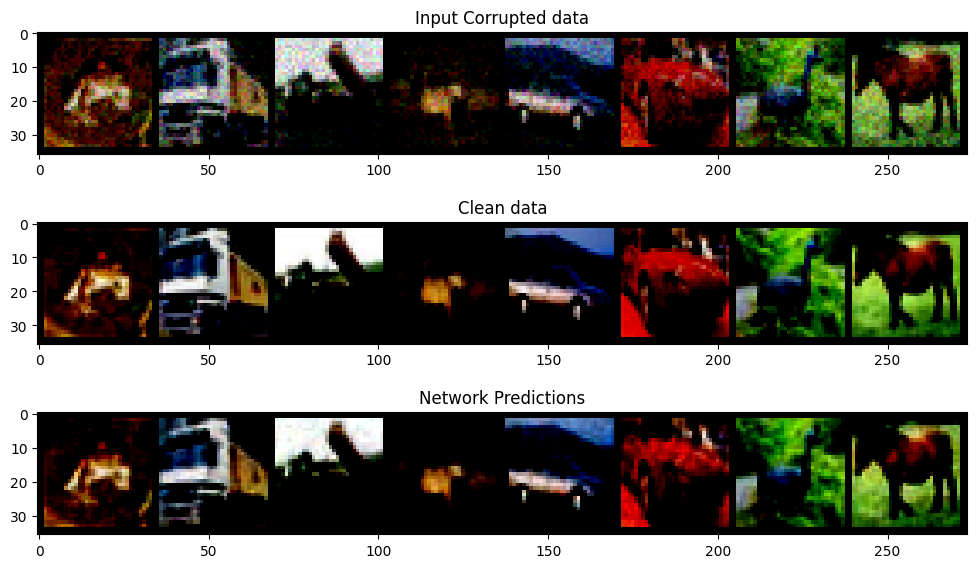

0.4
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.061714
Finished epoch 1. Average loss for this epoch: 0.054034
Finished epoch 2. Average loss for this epoch: 0.053325
Finished epoch 3. Average loss for this epoch: 0.052940
Finished epoch 4. Average loss for this epoch: 0.052669


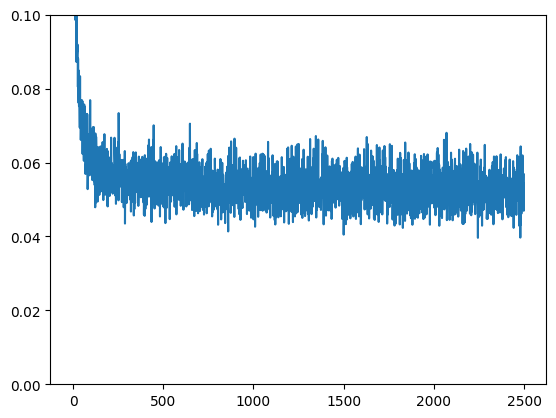

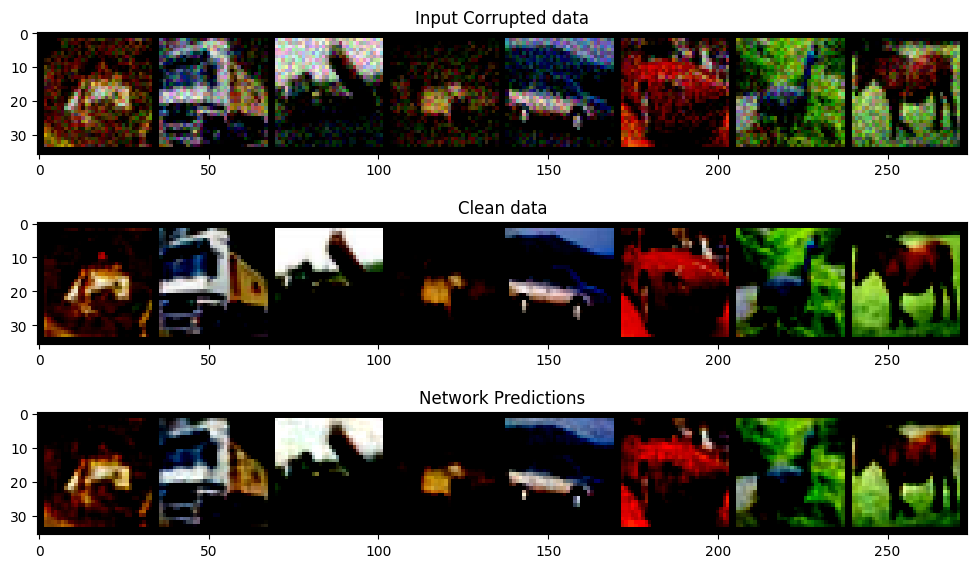

0.5
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.068815
Finished epoch 1. Average loss for this epoch: 0.058055
Finished epoch 2. Average loss for this epoch: 0.056837
Finished epoch 3. Average loss for this epoch: 0.056221
Finished epoch 4. Average loss for this epoch: 0.055809


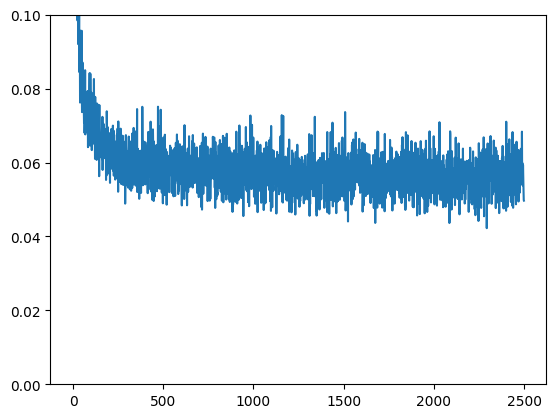

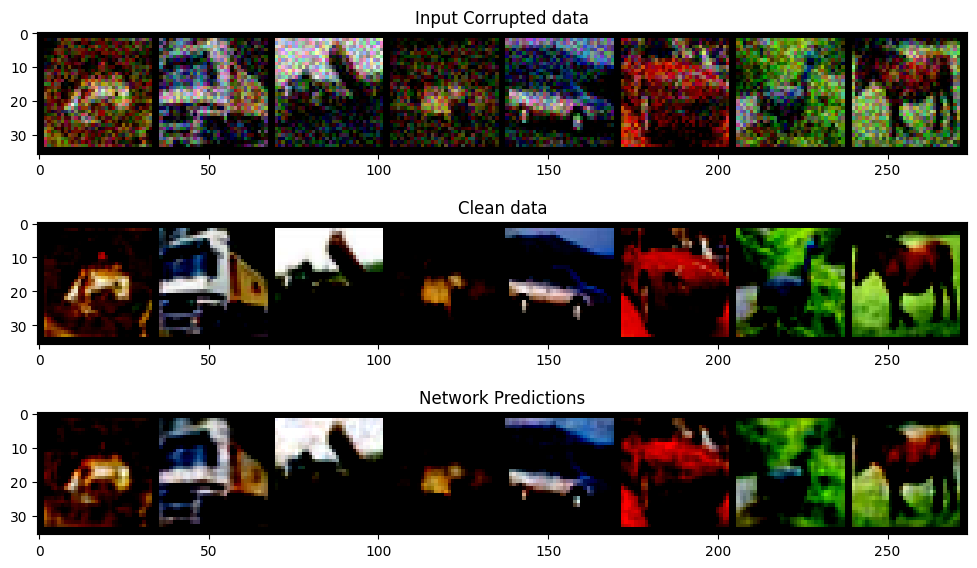

0.6000000000000001
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.081095
Finished epoch 1. Average loss for this epoch: 0.063842
Finished epoch 2. Average loss for this epoch: 0.062110
Finished epoch 3. Average loss for this epoch: 0.061056
Finished epoch 4. Average loss for this epoch: 0.060281


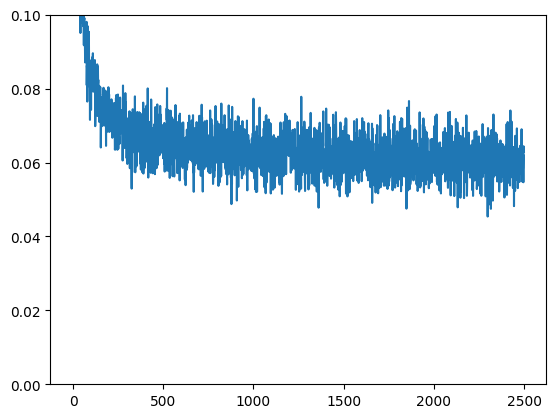

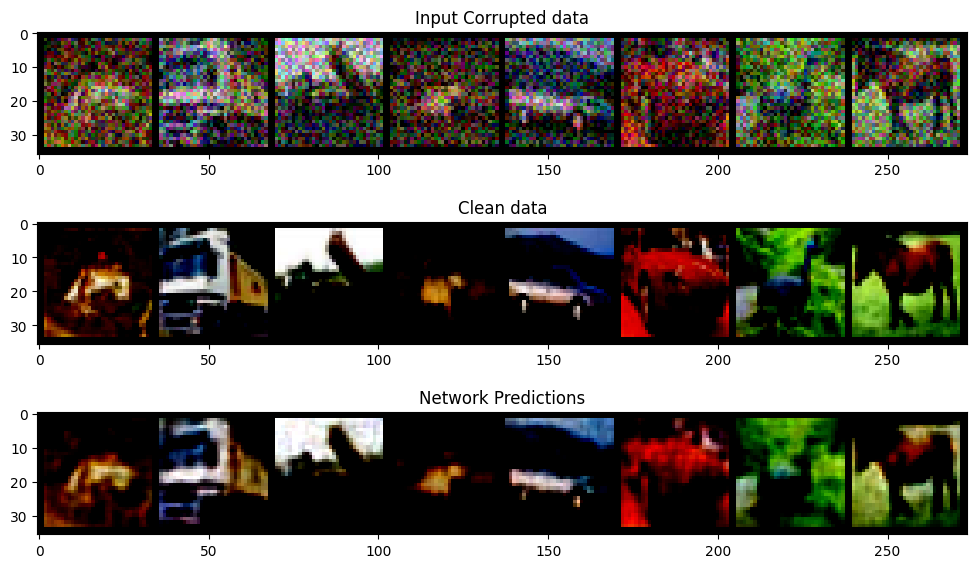

0.7000000000000001
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.078338
Finished epoch 1. Average loss for this epoch: 0.068764
Finished epoch 2. Average loss for this epoch: 0.066941
Finished epoch 3. Average loss for this epoch: 0.065944
Finished epoch 4. Average loss for this epoch: 0.065272


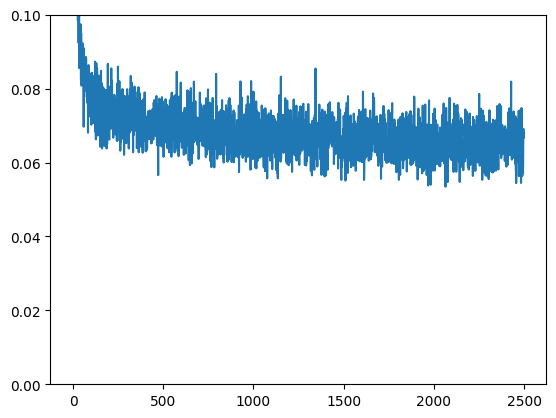

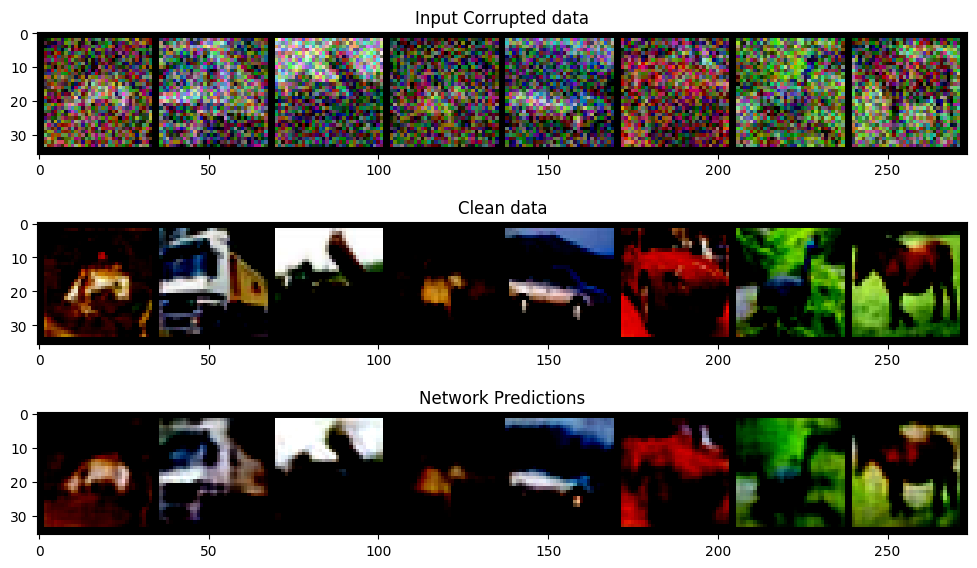

0.8
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.094325
Finished epoch 1. Average loss for this epoch: 0.081972
Finished epoch 2. Average loss for this epoch: 0.079557
Finished epoch 3. Average loss for this epoch: 0.078338
Finished epoch 4. Average loss for this epoch: 0.077619


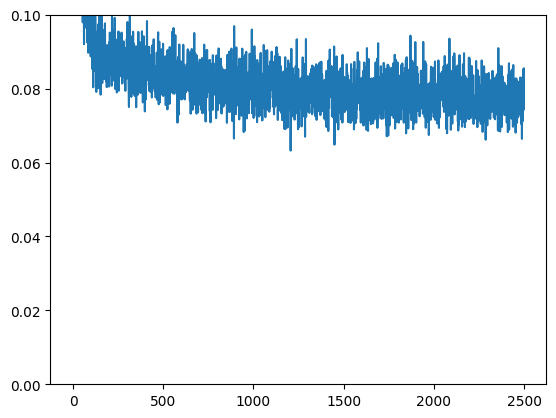

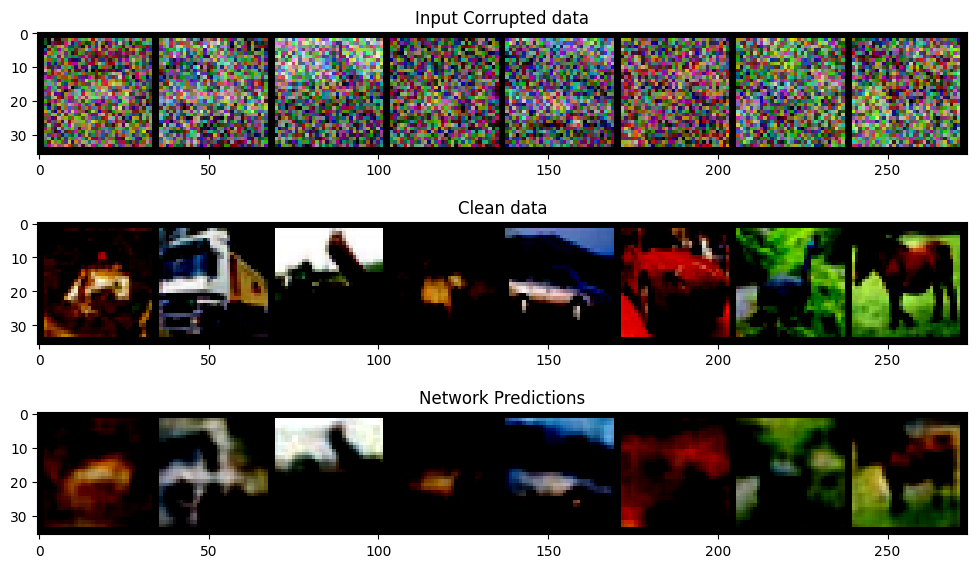

0.9
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.137218
Finished epoch 1. Average loss for this epoch: 0.112520
Finished epoch 2. Average loss for this epoch: 0.109415
Finished epoch 3. Average loss for this epoch: 0.108230
Finished epoch 4. Average loss for this epoch: 0.106741


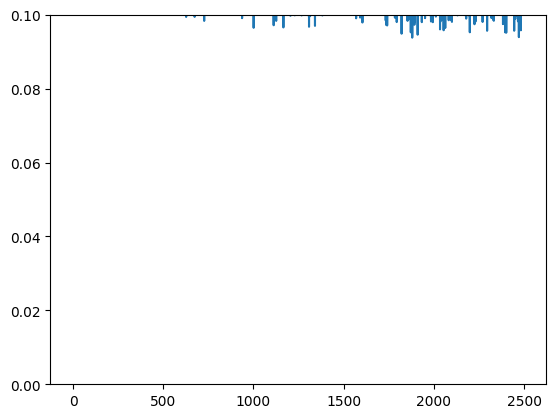

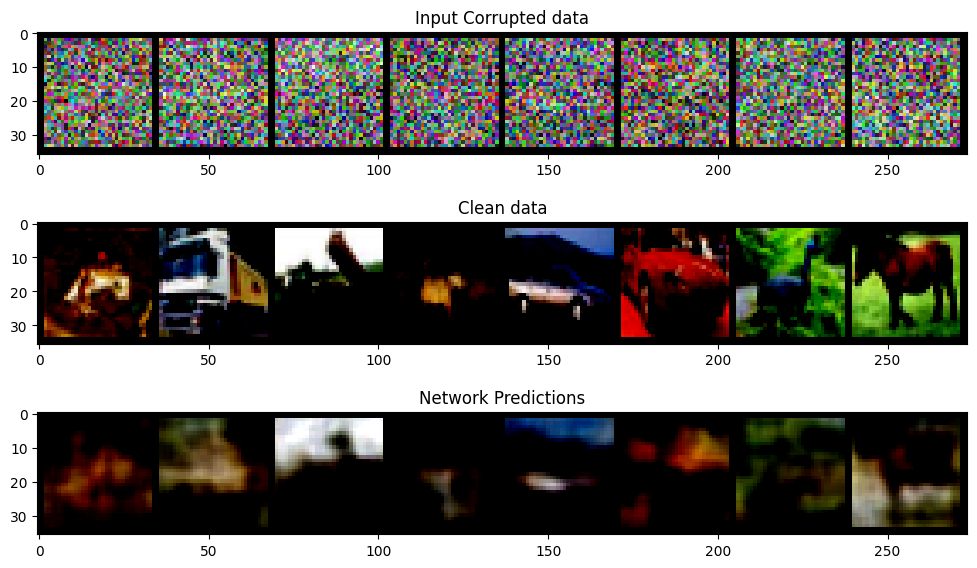

In [12]:
import numpy as np
models = []
worst_images = []
for i in np.arange(0, 1, 0.1):
    print(i)
    worst_images.append(prediction_for_noise_level(i))


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


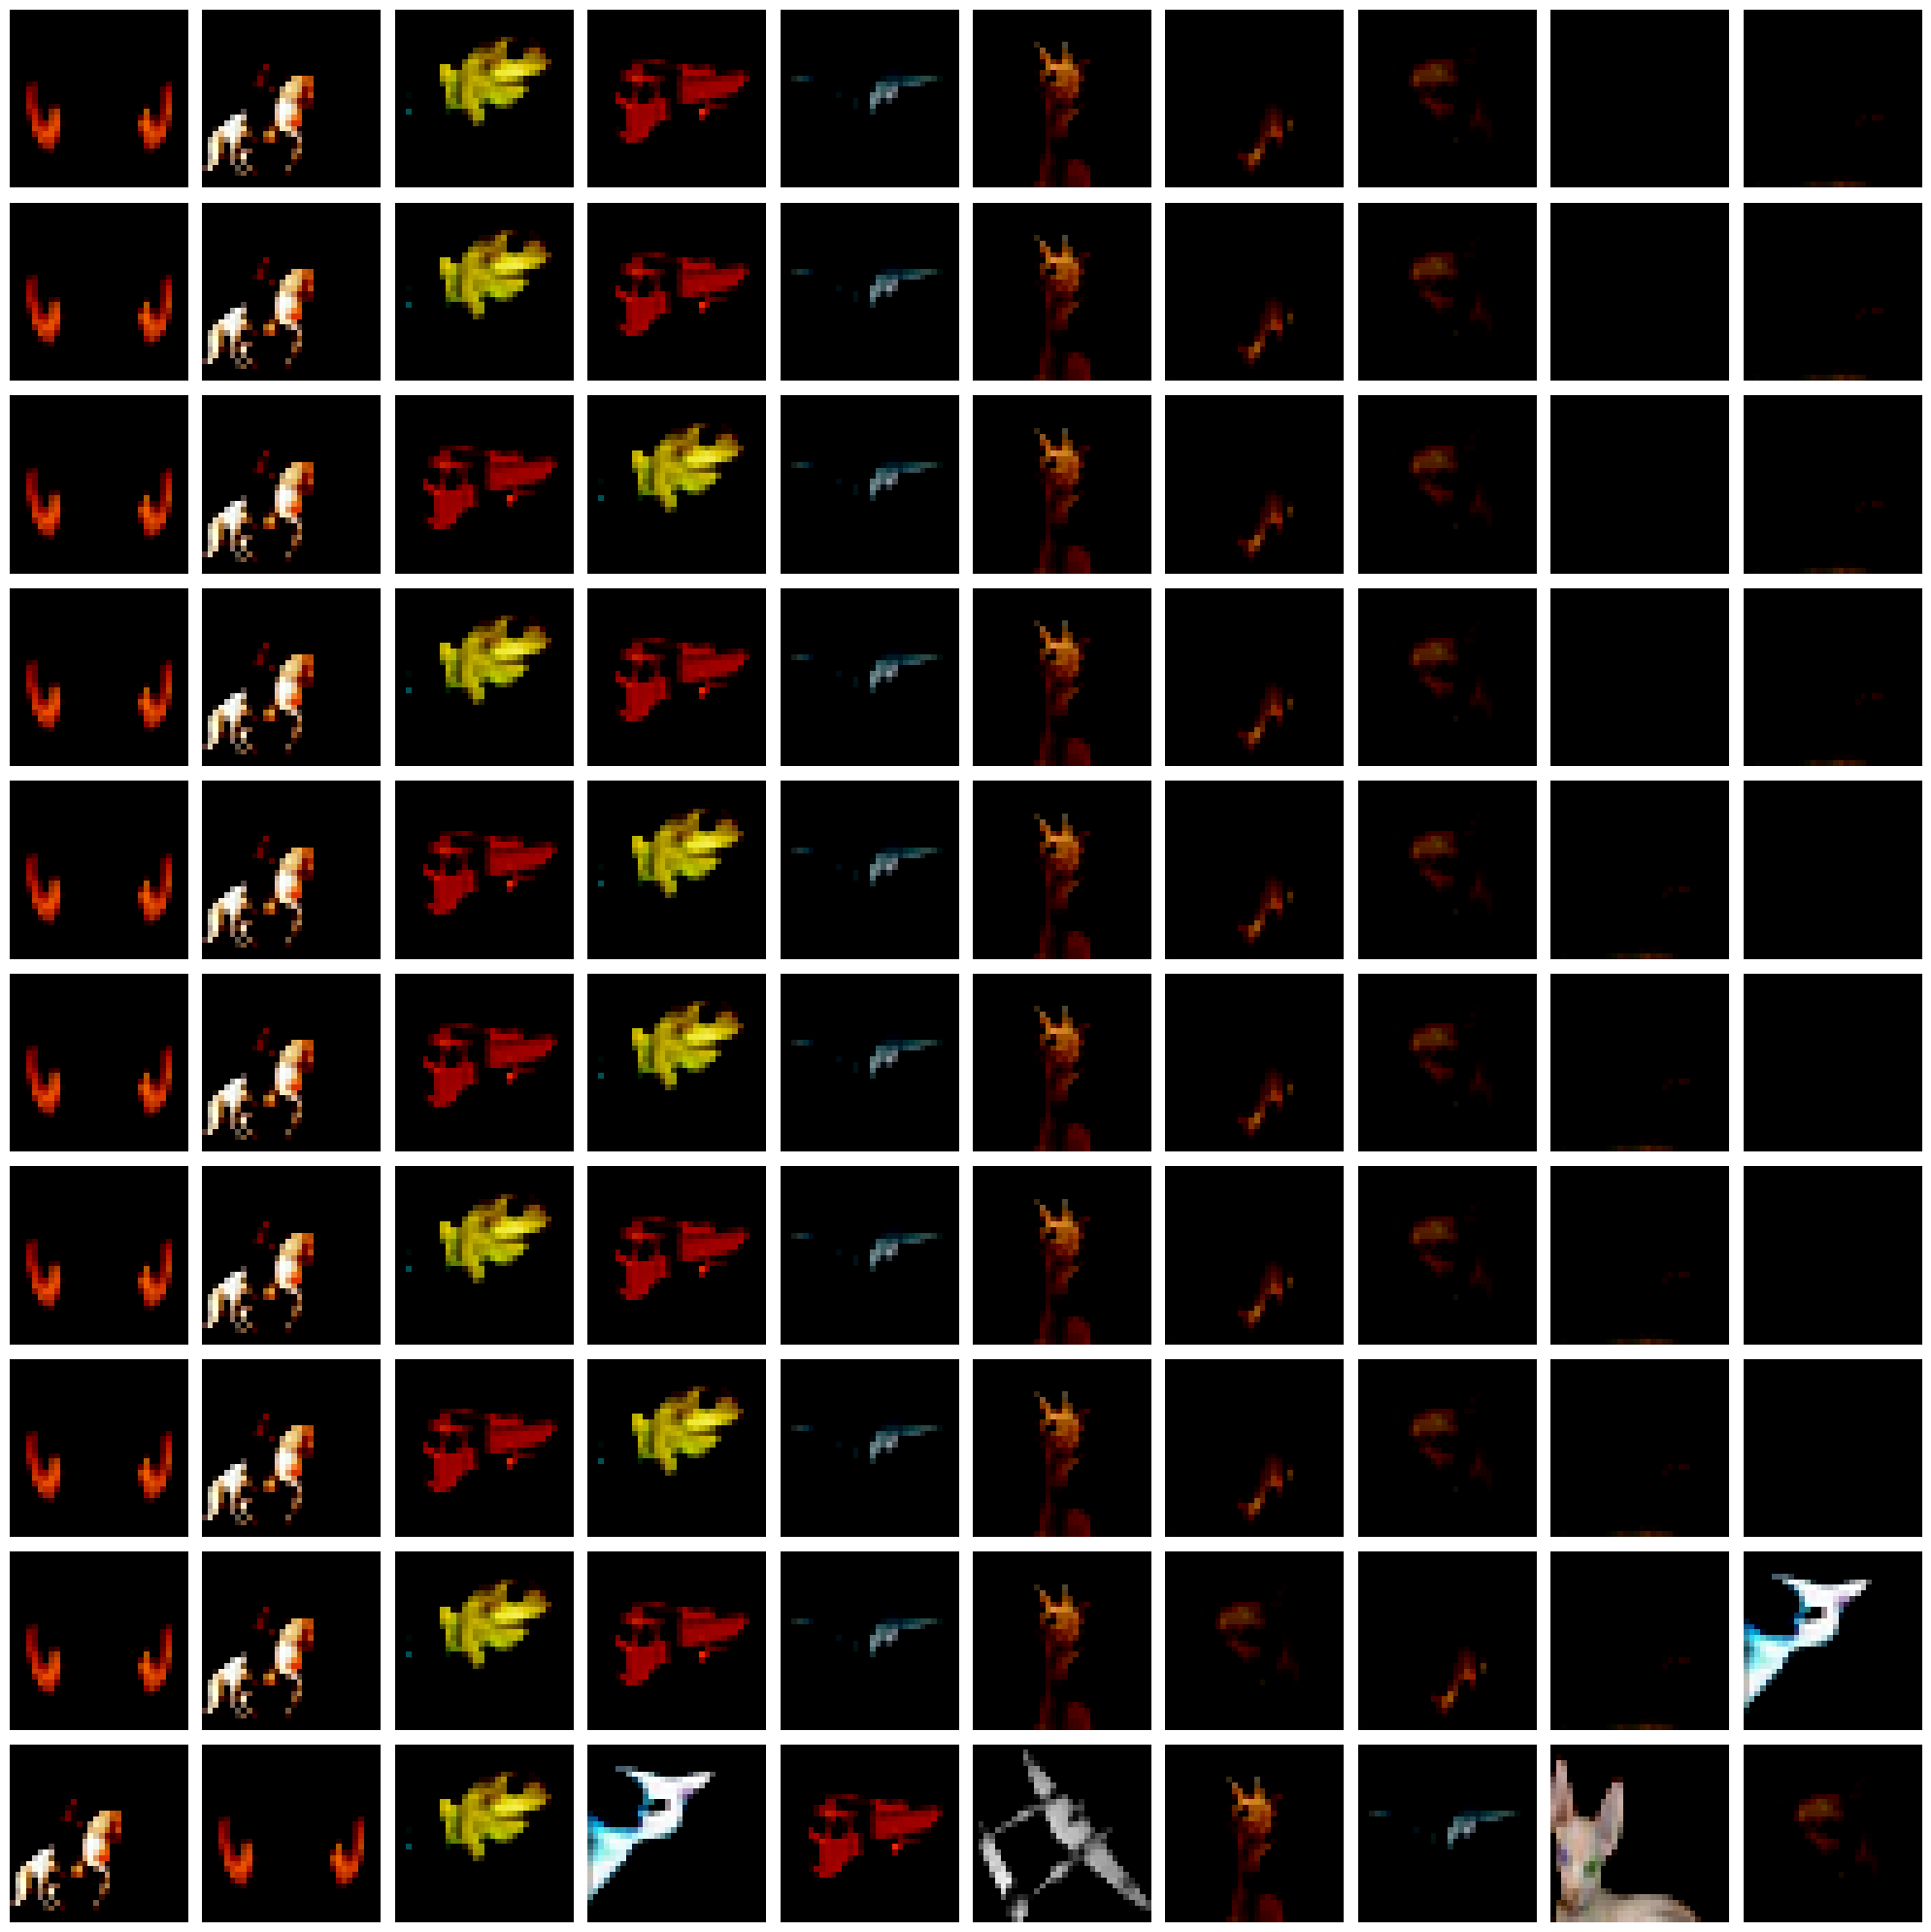

In [13]:
# Define number of rows and columns for the subplot grid
n_rows = len(worst_images)
n_cols = 10  # Assuming you want to display 10 images per noise level
noise = np.arange(0, 1, 0.1)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 2 * n_rows))

for i, row in enumerate(worst_images):
    print(noise[i])
    for j, img_index in enumerate(row):
        ax = axes[i, j]
        img = img_index[1].numpy()  # Assuming the image is the first element in the tuple and needs to be converted from a tensor
        img = np.transpose(img, (1, 2, 0))  # Transpose to make channel last
        ax.imshow(img, cmap='gray' if img.shape[2] == 1 else None)
        ax.axis('off')
    axes[i, 0].set_ylabel(f"Noise {i * 0.1:.1f}", size='large')

plt.tight_layout()
plt.show()


# Starting with Pretrained Model

In [14]:
import torch.nn as nn
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

In [15]:
net = BasicUNet().cuda()
x = torch.rand(8, 3, 32, 32).cuda()
net(x).shape

torch.Size([8, 3, 32, 32])

Finished epoch 0. Average loss for this epoch: 0.055193
Finished epoch 1. Average loss for this epoch: 0.049176
Finished epoch 2. Average loss for this epoch: 0.048551


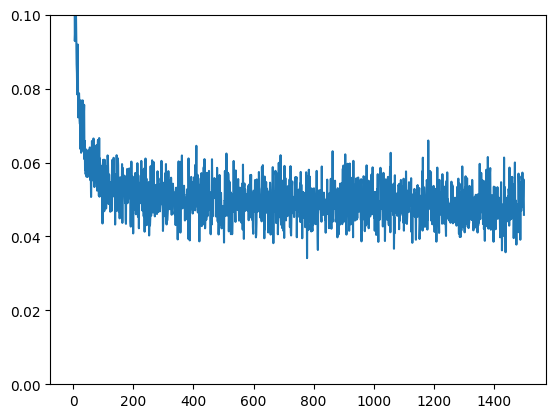

In [16]:
# Dataloader (you can mess with batch size)
# batch_size = 128
# trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
device = "cuda"
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in trainloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
#         noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
#         noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(trainloader):])/len(trainloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

In [17]:

def prediction_for_noise_level(noise, net):
    
    # Function 
    import torch
    import torchvision
    import torchvision.transforms as transforms
    from torch.utils.data import Dataset
    import matplotlib.pyplot as plt
    import numpy as np
    # Define the transform to normalize the data
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Initialize the dataset with noise corruption
    trainset = NoisyCIFAR10(root='./data', train=True, transform=transform, noise_level=noise)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
    testset = NoisyCIFAR10(root='./data', train=False, transform=transform, noise_level=noise)
    testloader = torch.utils.data.DataLoader(trainset, batch_size=100, num_workers=2)

    # Example: Display some images
    dataiter = next(iter(trainloader))
    images, labels = dataiter

    def imshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    # Dataloader (you can mess with batch size)
    # batch_size = 128
    # trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # How many runs through the data should we do?
    device = "cuda"
    n_epochs = 5

    # Our loss function
    loss_fn = nn.MSELoss()

    # The optimizer
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)

    # Keeping a record of the losses for later viewing
    losses = []

    # The training loop
    for epoch in range(n_epochs):

        for x, y in trainloader:

            # Get some data and prepare the corrupted version
            x = x.to(device) # Data on the GPU
            y = y.to(device)
    #         noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
    #         noisy_x = corrupt(x, noise_amount) # Create our noisy x

            # Get the model prediction
            pred = net(x)

            # Calculate the loss
            loss = loss_fn(pred, y) # How close is the output to the true 'clean' x?

            # Backprop and update the params:
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Store the loss for later
            losses.append(loss.item())

        # Print our the average of the loss values for this epoch:
        avg_loss = sum(losses[-len(trainloader):])/len(trainloader)
        print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')
    
    models.append(net)
        
    max_losses = []
    indices = []

    # Iterate over the testset without using a DataLoader to get index easily
    for index, (x, y) in enumerate(testset):
        with torch.no_grad():
            # Prepare the sample by adding a batch dimension and moving to the device
            x, y = x.unsqueeze(dim=0).to(device), y.unsqueeze(dim=0).to(device)

            # Get the model prediction
            pred = net(x)

            # Calculate the loss, assuming a simple MSE for individual predictions
            loss = ((pred - y) ** 2).mean().item()  # Calculating mean squared error

            # Store the loss and the corresponding index
            max_losses.append(loss)
            indices.append(index)

    # Combine the losses with their indices and sort them by loss
    indexed_losses = list(zip(max_losses, indices))
    indexed_losses.sort(reverse=True, key=lambda x: x[0])  # Sort by loss descending

    # Get the indices of the worst predictions
    worst_indices = [testset[idx] for _, idx in indexed_losses[:10]]
            
    # View the loss curve
    plt.plot(losses)
    plt.ylim(0, 0.1);
    import torch
    import torchvision
    import torchvision.transforms as transforms
    import matplotlib.pyplot as plt

    # Assuming `net` is your trained model and `device` is set (e.g., 'cuda' or 'cpu')

    # Get a batch of training data
    x, y = next(iter(testloader))
    x = x[:8]  # Only using the first 8 for easy plotting
    y = y[:8]

    # Assuming you have a `corrupt` function that adds noise to images
    # amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
    # noised_x = corrupt(x, amount)

    # Get the model predictions
    with torch.no_grad():
        preds = net(x.to(device)).detach().cpu()

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(12, 7))

    # Display the original input data
    axs[0].set_title('Input Corrupted data')
    axs[0].imshow(np.transpose(torchvision.utils.make_grid(x, nrow=8).numpy(), (1, 2, 0)).clip(0, 1))

#     If you want to show corrupted data, uncomment the following lines:
    axs[1].set_title('Clean data')
    axs[1].imshow(np.transpose(torchvision.utils.make_grid(y, nrow=8).numpy(), (1, 2, 0)).clip(0, 1))

    # Display the network predictions
    axs[2].set_title('Network Predictions')
    axs[2].imshow(np.transpose(torchvision.utils.make_grid(preds, nrow=8).numpy(), (1, 2, 0)).clip(0, 1))

    plt.show()
    
    return worst_indices
    

# Display images
# imshow(torchvision.utils.make_grid(images))
# plt.show()


0.0
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.048594
Finished epoch 1. Average loss for this epoch: 0.048092
Finished epoch 2. Average loss for this epoch: 0.047930
Finished epoch 3. Average loss for this epoch: 0.047803
Finished epoch 4. Average loss for this epoch: 0.047697


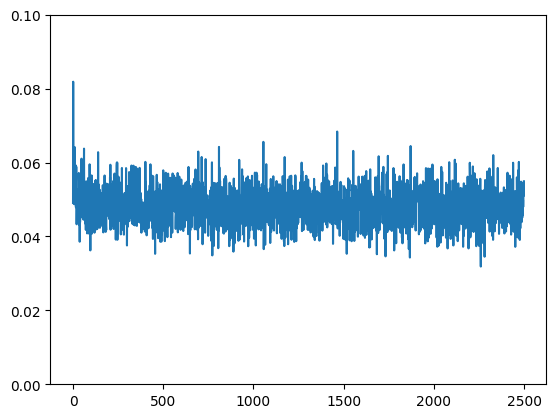

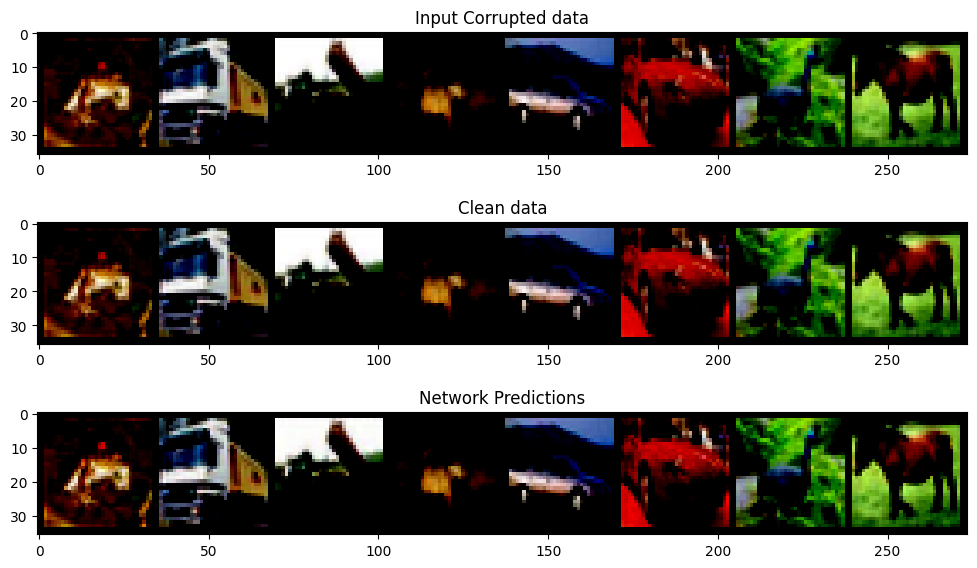

0.1
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.048749
Finished epoch 1. Average loss for this epoch: 0.048393
Finished epoch 2. Average loss for this epoch: 0.048227
Finished epoch 3. Average loss for this epoch: 0.048120
Finished epoch 4. Average loss for this epoch: 0.048029


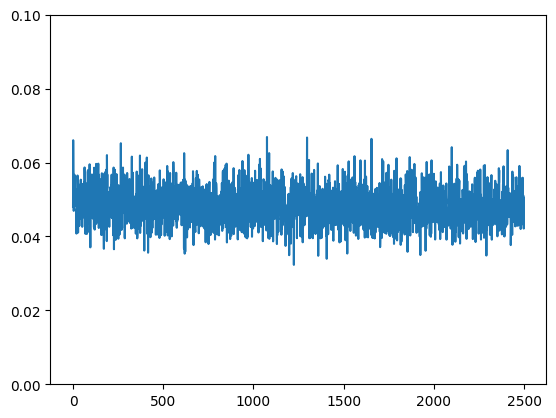

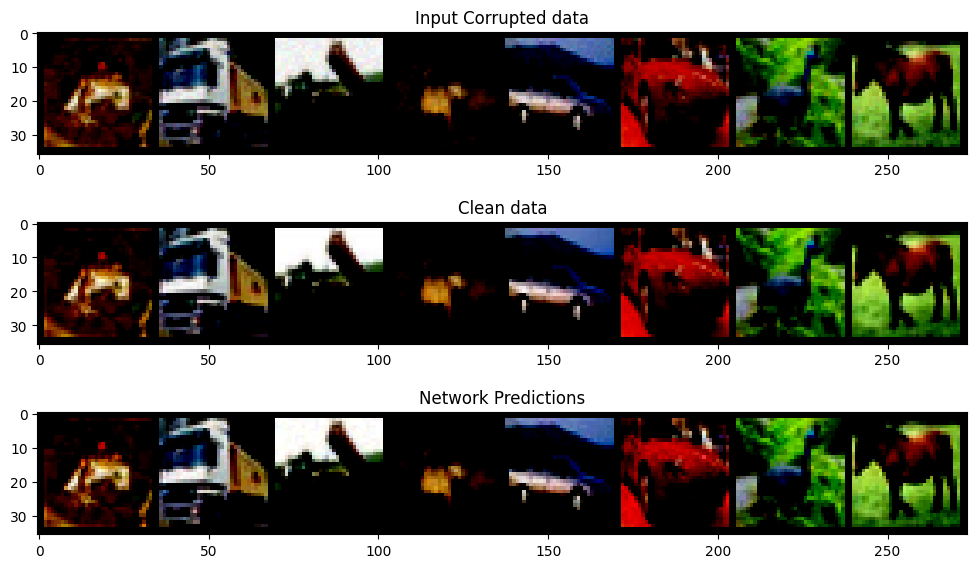

0.2
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.049851
Finished epoch 1. Average loss for this epoch: 0.049370
Finished epoch 2. Average loss for this epoch: 0.049210
Finished epoch 3. Average loss for this epoch: 0.049082
Finished epoch 4. Average loss for this epoch: 0.048975


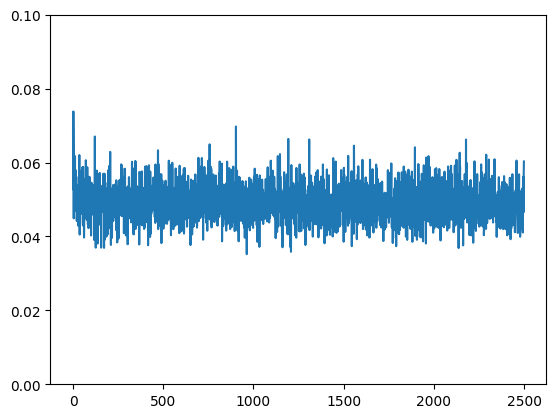

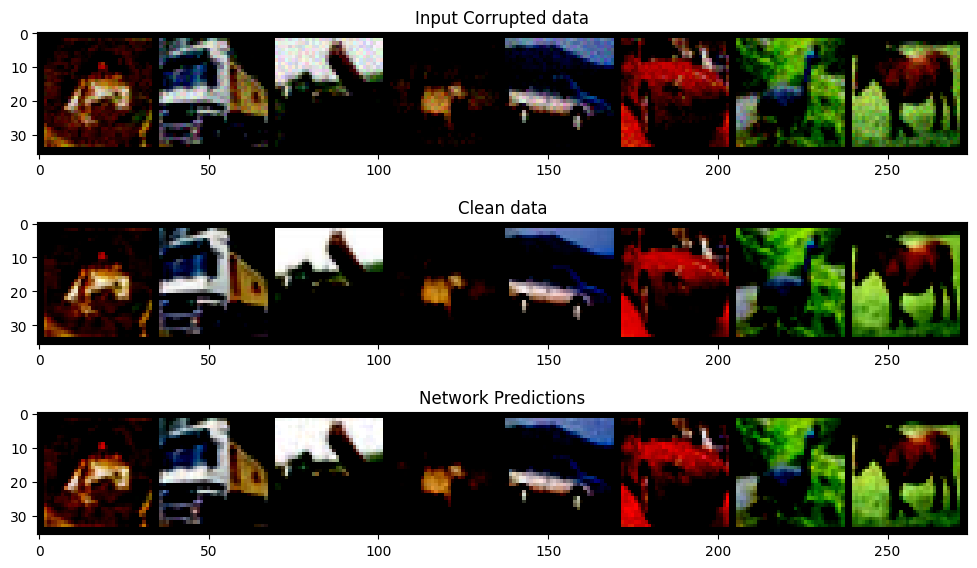

0.30000000000000004
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.051420
Finished epoch 1. Average loss for this epoch: 0.050738
Finished epoch 2. Average loss for this epoch: 0.050504
Finished epoch 3. Average loss for this epoch: 0.050318
Finished epoch 4. Average loss for this epoch: 0.050180


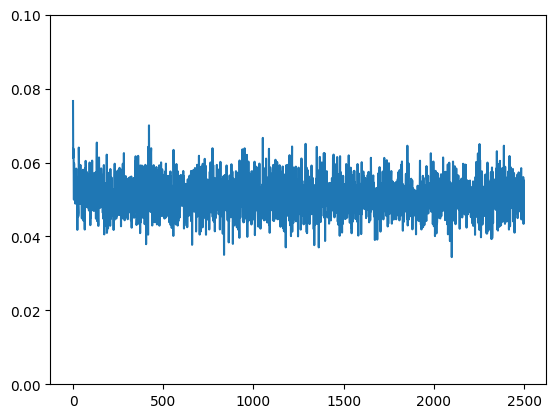

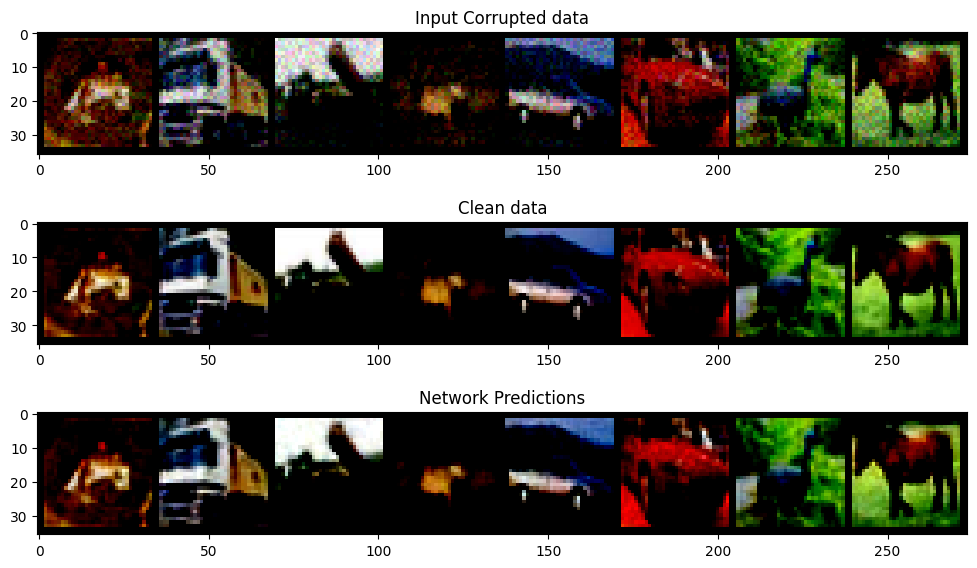

0.4
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.054250
Finished epoch 1. Average loss for this epoch: 0.052876
Finished epoch 2. Average loss for this epoch: 0.052504
Finished epoch 3. Average loss for this epoch: 0.052244
Finished epoch 4. Average loss for this epoch: 0.052041


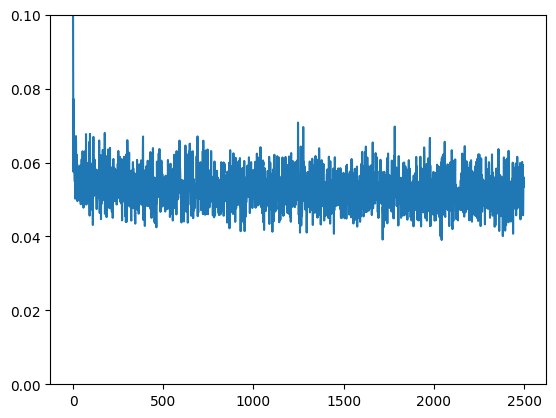

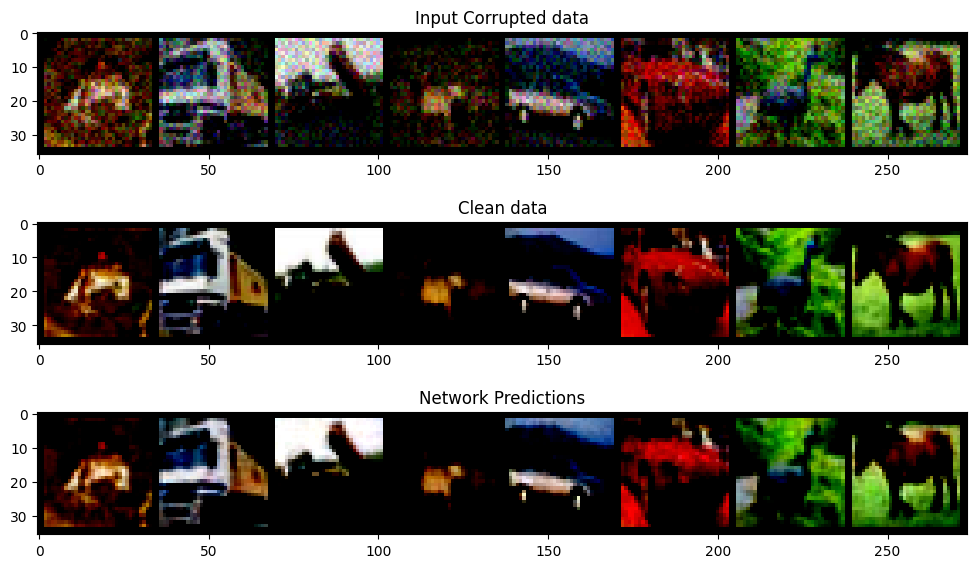

0.5
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.058493
Finished epoch 1. Average loss for this epoch: 0.055804
Finished epoch 2. Average loss for this epoch: 0.055253
Finished epoch 3. Average loss for this epoch: 0.054886
Finished epoch 4. Average loss for this epoch: 0.054633


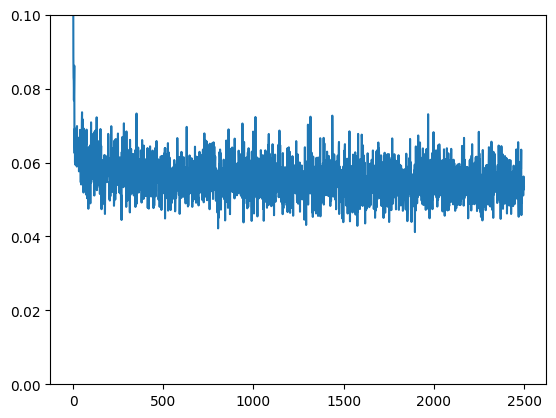

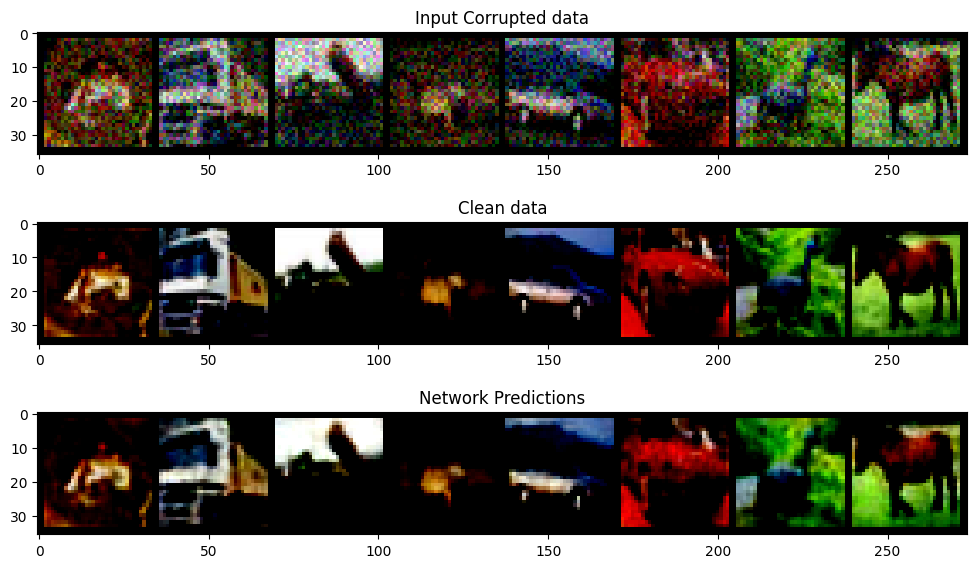

0.6000000000000001
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.064715
Finished epoch 1. Average loss for this epoch: 0.060231
Finished epoch 2. Average loss for this epoch: 0.059330
Finished epoch 3. Average loss for this epoch: 0.058818
Finished epoch 4. Average loss for this epoch: 0.058477


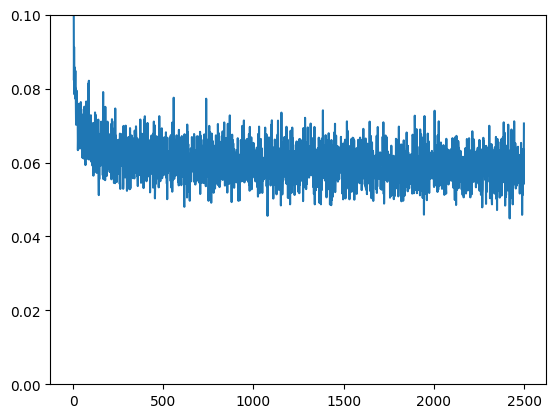

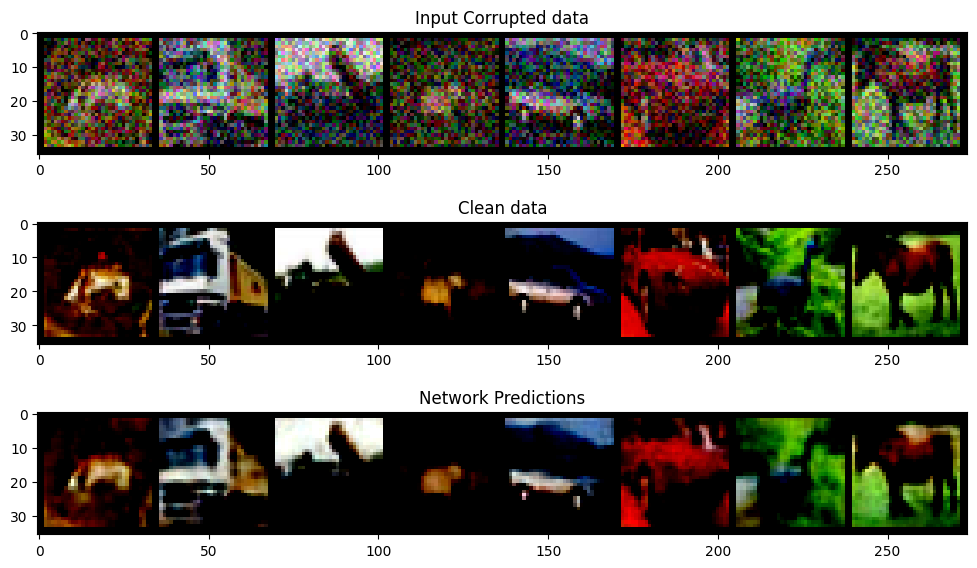

0.7000000000000001
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.074200
Finished epoch 1. Average loss for this epoch: 0.067309
Finished epoch 2. Average loss for this epoch: 0.066001
Finished epoch 3. Average loss for this epoch: 0.065246
Finished epoch 4. Average loss for this epoch: 0.064806


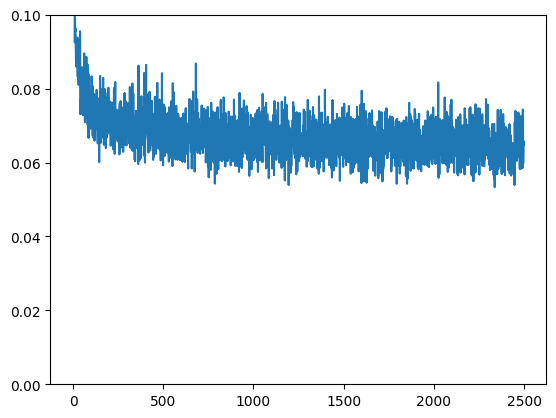

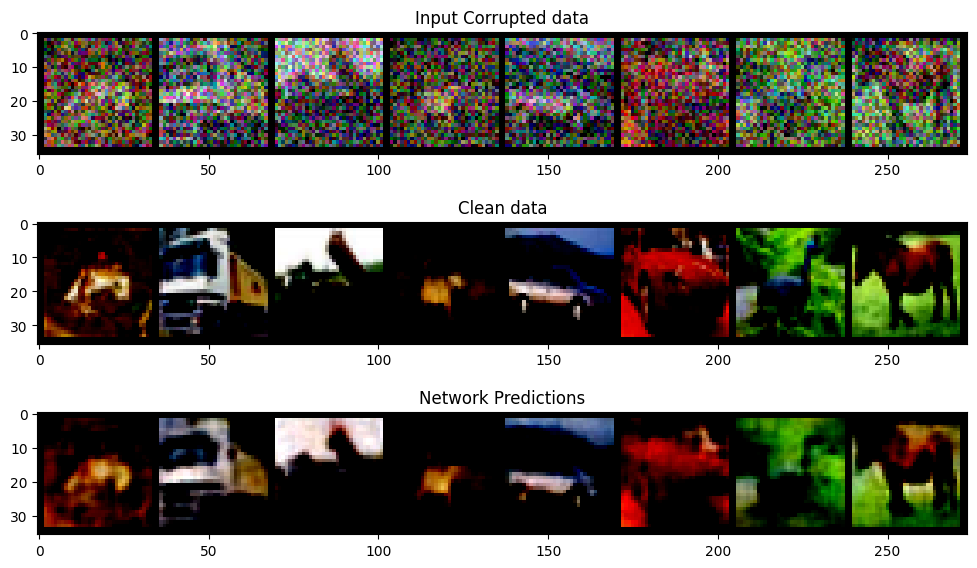

0.8
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.090238
Finished epoch 1. Average loss for this epoch: 0.079924
Finished epoch 2. Average loss for this epoch: 0.078200
Finished epoch 3. Average loss for this epoch: 0.077339
Finished epoch 4. Average loss for this epoch: 0.076797


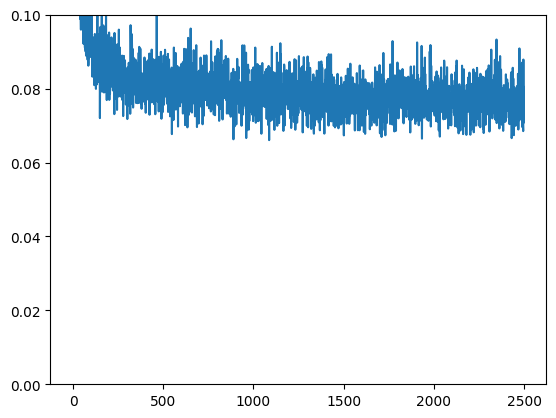

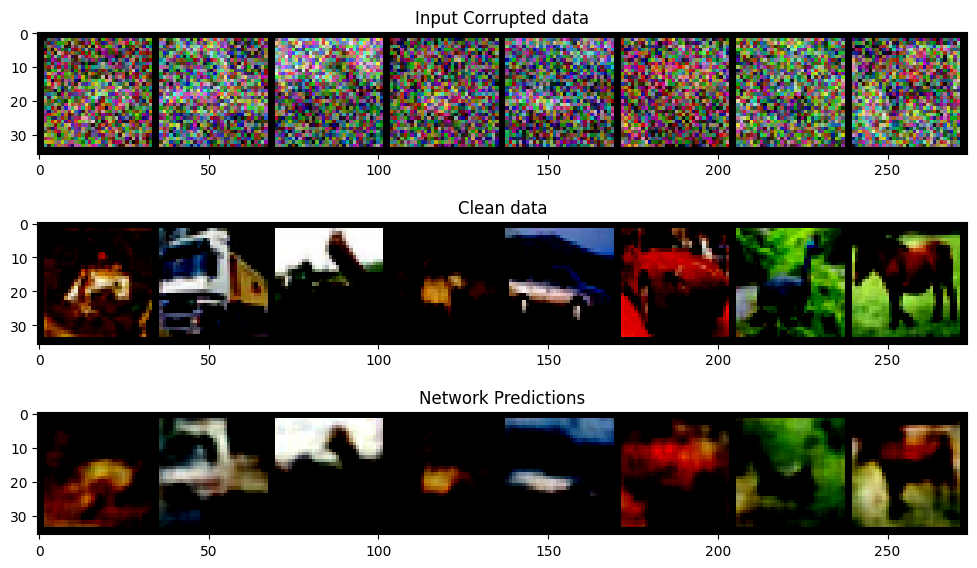

0.9
Files already downloaded and verified
Files already downloaded and verified
Finished epoch 0. Average loss for this epoch: 0.130338
Finished epoch 1. Average loss for this epoch: 0.110830
Finished epoch 2. Average loss for this epoch: 0.108528
Finished epoch 3. Average loss for this epoch: 0.107175
Finished epoch 4. Average loss for this epoch: 0.106094


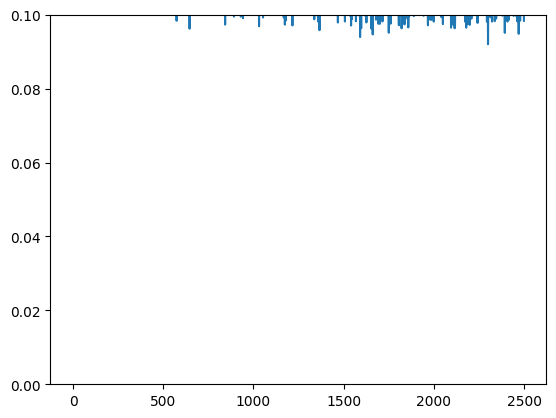

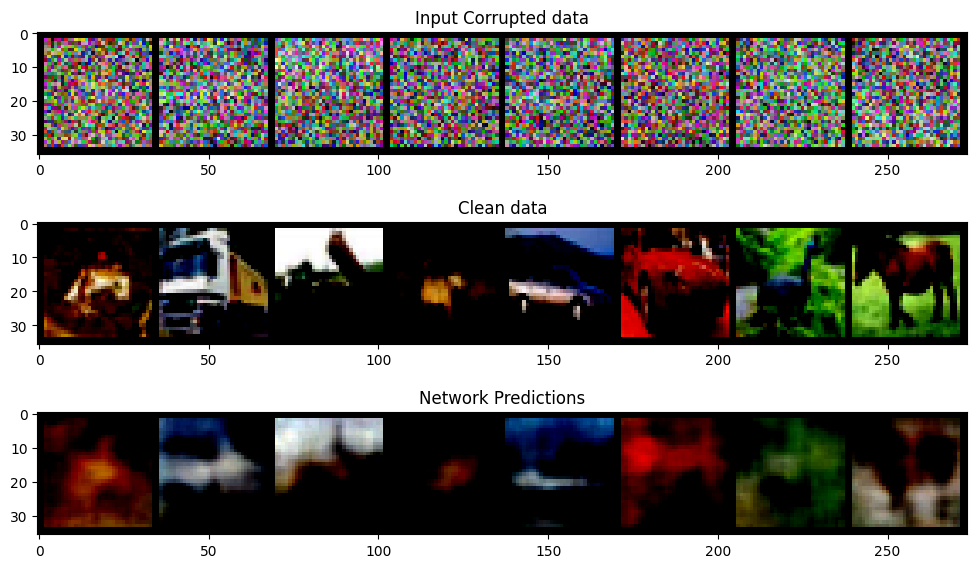

In [18]:
import numpy as np
models = []
worst_images = []
import copy


for i in np.arange(0, 1, 0.1):
    trained_net = copy.deepcopy(net)
    print(i)
    worst_images.append(prediction_for_noise_level(i, trained_net))


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


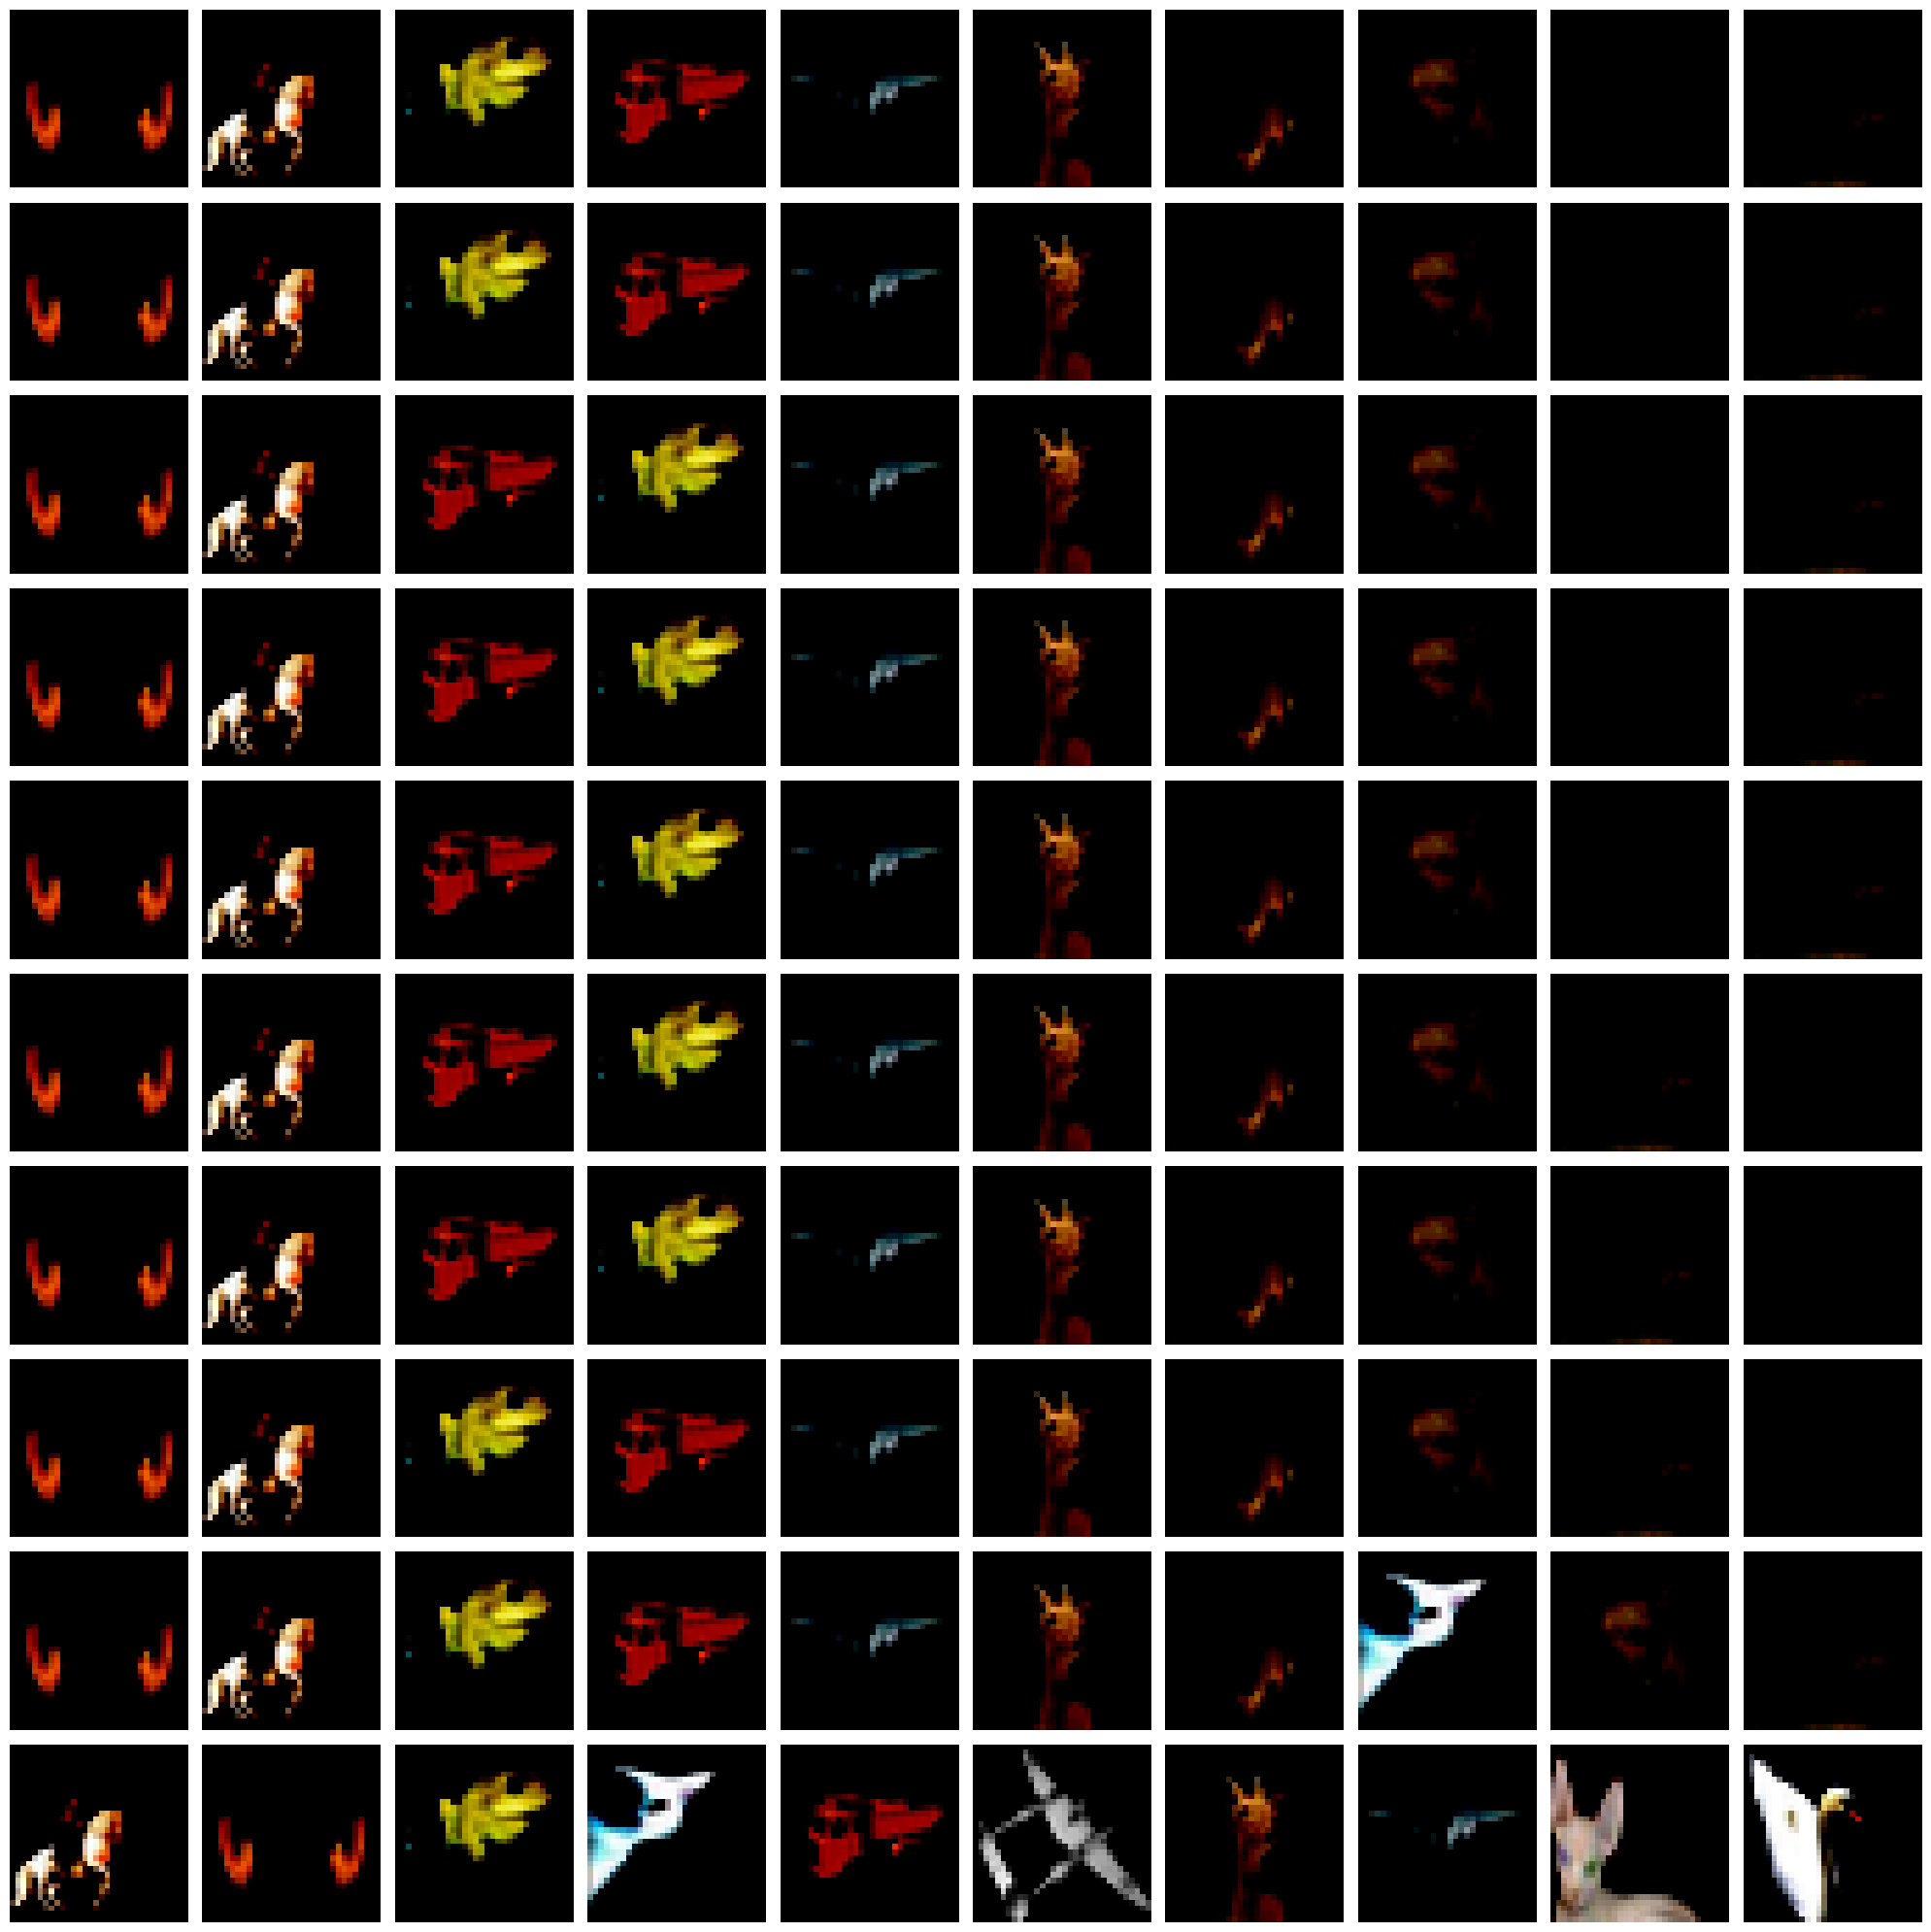

In [19]:
# Define number of rows and columns for the subplot grid
n_rows = len(worst_images)
n_cols = 10  # Assuming you want to display 10 images per noise level
noise = np.arange(0, 1, 0.1)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 2 * n_rows))

for i, row in enumerate(worst_images):
    print(noise[i])
    for j, img_index in enumerate(row):
        ax = axes[i, j]
        img = img_index[1].numpy()  # Assuming the image is the first element in the tuple and needs to be converted from a tensor
        img = np.transpose(img, (1, 2, 0))  # Transpose to make channel last
        ax.imshow(img, cmap='gray' if img.shape[2] == 1 else None)
        ax.axis('off')
    axes[i, 0].set_ylabel(f"Noise {i * 0.1:.1f}", size='large')

plt.tight_layout()
plt.show()


# Matroyksha Diffusion Model

In [20]:
import torch
import torch.nn as nn
from typing import List

class NestedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_channels, 3, kernel_size=5, padding=2),
            nn.SiLU(),
            nn.Conv2d(3, 3, kernel_size=5, padding=2),
            nn.SiLU(),
            nn.MaxPool2d(2)
        )
        self.mid = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=5, padding=2),
            nn.SiLU()
        )
        self.up = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=5, padding=2),  # Now expecting 128 channels (64+64)
            nn.SiLU(),
            nn.Conv2d(3, 3, kernel_size=5, padding=2),
            nn.SiLU(),
            nn.Conv2d(3, out_channels, kernel_size=5, padding=2),
            nn.SiLU(),
            nn.Upsample(scale_factor=2)
        )
        self.skip = nn.Conv2d(3, 3, kernel_size=1)  # Adjust skip connection to handle 128 channels

    def forward(self, z: List[torch.Tensor], h: torch.Tensor = None, o: List[torch.Tensor] = []):
        x = z[-1] if h is None else z[-1]+h
        print(f"z-1: {x.shape}")

        if len(z) > 1:
            # Recursively move to next nesting level
            x = self.skip((self.up(self.forward(z[:-1], self.down(z[-1]), o))) + x)
        else:
            # Lowest resolution, apply mid and up layers
            print(f"in else: {x.shape}")
            x = self.skip(self.up(self.mid(self.down(x)))+x) 
            print(x.shape)
        
        o.append(x)
        return x

# Testing the implementation on CPU
o = []
net = NestedUNet(in_channels=3, out_channels=3)
x = [ torch.rand(8, 3, 8, 8),torch.rand(8, 3, 16, 16),  torch.rand(8, 3, 32, 32)]
# x = [ torch.rand(8, 3, 8, 8)]
output = net(x, None, o)
print("output")
o[0].shape, o[1].shape, o[2].shape



z-1: torch.Size([8, 3, 32, 32])
z-1: torch.Size([8, 3, 16, 16])
z-1: torch.Size([8, 3, 8, 8])
in else: torch.Size([8, 3, 8, 8])
torch.Size([8, 3, 8, 8])
output


(torch.Size([8, 3, 8, 8]),
 torch.Size([8, 3, 16, 16]),
 torch.Size([8, 3, 32, 32]))